In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

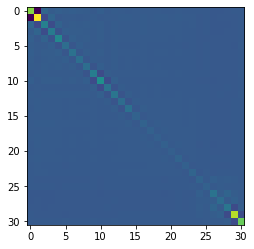

In [4]:
plt.imshow(syscov)

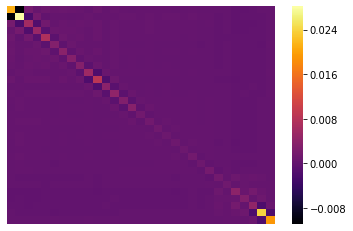

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [6]:
np.min(np.abs(syscov)), np.max(np.abs(syscov)) #checking non-negatives in the diagonal

(1.695011341e-07, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [7]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001*err
    covset_noise[i] = syscov + 0.05*err

 Generating 1000 matrix 

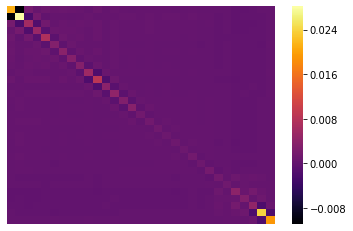

In [8]:
val, vec = np.linalg.eigh(syscov)
D = np.diag(val)
new = (vec+0.1) @ (D) @ (vec+0.1).T
sns.heatmap(pd.DataFrame(syscov), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

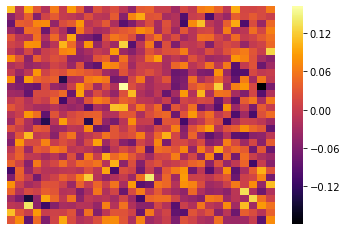

In [53]:
sns.heatmap(pd.DataFrame(covset_noise[100]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [10]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


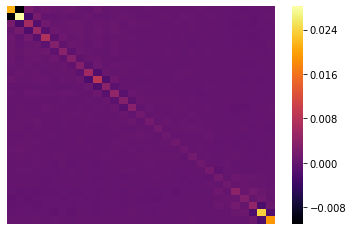

In [11]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [12]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(300, activation='tanh')(input_img)
x = layers.Dense(200, activation='tanh')(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)

#begin decoder
x = layers.Dense(200, activation='tanh')(encoded)
x = layers.Dense(300, activation='tanh')(x)
decoded = layers.Dense(31*31, activation='linear')(x)

# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 300)               288600    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_2 (Dense)              (None, 31)                6231      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               6400      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_5 (Dense)              (None, 961)              

In [13]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=300,
                batch_size=16,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/300
50/50 [==============================] - 0s 9ms/step - loss: 1.8165e-04 - val_loss: 2.0530e-05
Epoch 2/300
50/50 [==============================] - 0s 5ms/step - loss: 7.5602e-06 - val_loss: 7.4065e-06
Epoch 3/300
50/50 [==============================] - 0s 6ms/step - loss: 3.1411e-06 - val_loss: 4.3587e-06
Epoch 4/300
50/50 [==============================] - 0s 6ms/step - loss: 1.7819e-06 - val_loss: 2.8578e-06
Epoch 5/300
50/50 [==============================] - 0s 5ms/step - loss: 1.1369e-06 - val_loss: 2.0144e-06
Epoch 6/300
50/50 [==============================] - 0s 5ms/step - loss: 7.7421e-07 - val_loss: 1.5019e-06
Epoch 7/300
50/50 [==============================] - 0s 5ms/step - loss: 5.5711e-07 - val_loss: 1.1439e-06
Epoch 8/300
50/50 [==============================] - 0s 5ms/step - loss: 4.1282e-07 - val_loss: 9.0379e-07
Epoch 9/300
50/50 [==============================] - 0s 5ms/step - loss: 3.1881e-07 - val_loss: 7.2981e-07
Epoch 10/300
50/50 [=================

Epoch 77/300
50/50 [==============================] - 0s 6ms/step - loss: 1.6407e-08 - val_loss: 2.4067e-08
Epoch 78/300
50/50 [==============================] - 0s 6ms/step - loss: 1.6411e-08 - val_loss: 2.4990e-08
Epoch 79/300
50/50 [==============================] - 0s 6ms/step - loss: 1.6538e-08 - val_loss: 2.4556e-08
Epoch 80/300
50/50 [==============================] - 0s 6ms/step - loss: 1.6495e-08 - val_loss: 2.4116e-08
Epoch 81/300
50/50 [==============================] - 0s 5ms/step - loss: 1.8070e-08 - val_loss: 2.6525e-08
Epoch 82/300
50/50 [==============================] - 0s 6ms/step - loss: 1.8228e-08 - val_loss: 2.4715e-08
Epoch 83/300
50/50 [==============================] - 0s 5ms/step - loss: 1.6986e-08 - val_loss: 2.5184e-08
Epoch 84/300
50/50 [==============================] - 0s 6ms/step - loss: 1.8737e-08 - val_loss: 2.8429e-08
Epoch 85/300
50/50 [==============================] - 0s 6ms/step - loss: 2.2764e-08 - val_loss: 2.7822e-08


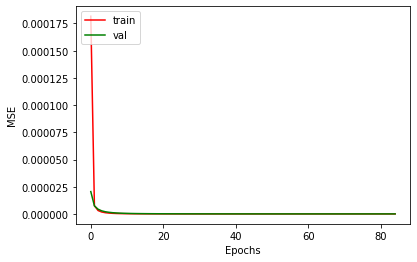

In [15]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [16]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

2.4024949141221444e-08 1.532933779913037e-08


In [17]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
np.min(encoded_imgs)

(200, 31)


-0.009198273

(200, 961)


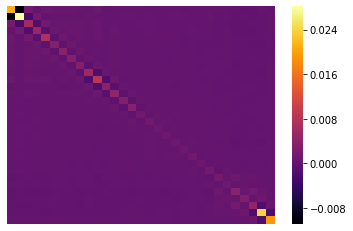

In [18]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


In [19]:
print(np.shape(decoded_imgs))

(200, 961)


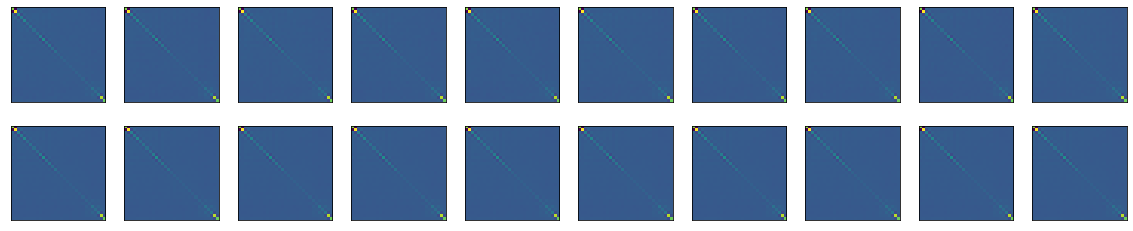

In [20]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

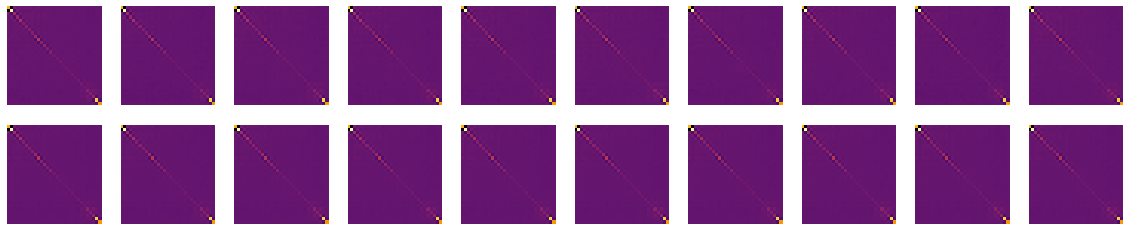

In [21]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

           z      $D_L$
0   0.010000  32.953887
1   0.011762  33.879003
2   0.013833  33.842141
3   0.016270  34.118567
4   0.019136  34.593446
5   0.022507  34.939027
6   0.026472  35.252096
7   0.031135  35.748502
8   0.036620  36.069788
9   0.043071  36.434570
10  0.050658  36.651111
11  0.059582  37.158014
12  0.070077  37.430173
13  0.082422  37.956616
14  0.096941  38.253254
15  0.114018  38.612869
16  0.134102  39.067851
17  0.157725  39.341402
18  0.185509  39.792144
19  0.218188  40.156535
20  0.256623  40.564956
21  0.301829  40.905288
22  0.354997  41.421417
23  0.417532  41.790923
24  0.491083  42.231461
25  0.577590  42.617047
26  0.679335  43.052731
27  0.799004  43.504151
28  0.939753  43.972573
29  1.105296  44.514088
30  1.300000  44.821867


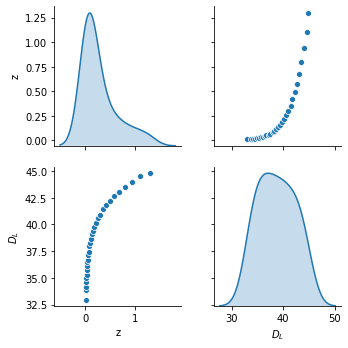

In [22]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [23]:
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
comp = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(comp)

data = data.values[shuffle]

In [24]:
z = data[:,0]
dl = data[:,1:]

In [25]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [26]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
dl_train, dl_test = np.split(dl, indx)

In [27]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.,
                                   patience=200,
                                   restore_best_weights=True)]

In [28]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(200, activation='relu')(efirst)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)

    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 1
epochs = 200
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_11 (Dense)             (None, 200)              

In [29]:
model_train = neural_model.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test),
                                    callbacks=callbacks)

Epoch 1/200
24/24 [==============================] - 0s 10ms/step - loss: 1162.4491 - val_loss: 639.7657
Epoch 2/200
24/24 [==============================] - 0s 3ms/step - loss: 434.7238 - val_loss: 434.7319
Epoch 3/200
24/24 [==============================] - 0s 3ms/step - loss: 434.3437 - val_loss: 509.7554
Epoch 4/200
24/24 [==============================] - 0s 3ms/step - loss: 178.0203 - val_loss: 79.5617
Epoch 5/200
24/24 [==============================] - 0s 3ms/step - loss: 36.6762 - val_loss: 49.8795
Epoch 6/200
24/24 [==============================] - 0s 4ms/step - loss: 37.2659 - val_loss: 155.6541
Epoch 7/200
24/24 [==============================] - 0s 6ms/step - loss: 20.4864 - val_loss: 41.1528
Epoch 8/200
24/24 [==============================] - 0s 3ms/step - loss: 11.6206 - val_loss: 57.6971
Epoch 9/200
24/24 [==============================] - 0s 3ms/step - loss: 9.9858 - val_loss: 14.1456
Epoch 10/200
24/24 [==============================] - 0s 4ms/step - loss: 3.4417 -

24/24 [==============================] - 0s 3ms/step - loss: 2.1714 - val_loss: 0.4129
Epoch 83/200
24/24 [==============================] - 0s 4ms/step - loss: 1.1245 - val_loss: 1.0852
Epoch 84/200
24/24 [==============================] - 0s 4ms/step - loss: 2.0730 - val_loss: 1.7256
Epoch 85/200
24/24 [==============================] - 0s 4ms/step - loss: 1.6807 - val_loss: 0.5721
Epoch 86/200
24/24 [==============================] - 0s 4ms/step - loss: 1.8387 - val_loss: 2.7775
Epoch 87/200
24/24 [==============================] - 0s 3ms/step - loss: 1.8841 - val_loss: 5.1909
Epoch 88/200
24/24 [==============================] - 0s 3ms/step - loss: 3.4445 - val_loss: 6.8936
Epoch 89/200
24/24 [==============================] - 0s 3ms/step - loss: 2.7277 - val_loss: 0.9883
Epoch 90/200
24/24 [==============================] - 0s 3ms/step - loss: 1.7262 - val_loss: 9.7685
Epoch 91/200
24/24 [==============================] - 0s 3ms/step - loss: 1.3579 - val_loss: 0.9738
Epoch 92/200


24/24 [==============================] - 0s 3ms/step - loss: 0.9937 - val_loss: 0.2807
Epoch 164/200
24/24 [==============================] - 0s 3ms/step - loss: 1.8862 - val_loss: 2.0404
Epoch 165/200
24/24 [==============================] - 0s 3ms/step - loss: 2.2549 - val_loss: 1.1693
Epoch 166/200
24/24 [==============================] - 0s 3ms/step - loss: 1.1921 - val_loss: 2.0256
Epoch 167/200
24/24 [==============================] - 0s 3ms/step - loss: 2.3313 - val_loss: 0.6128
Epoch 168/200
24/24 [==============================] - 0s 3ms/step - loss: 2.4863 - val_loss: 1.1753
Epoch 169/200
24/24 [==============================] - 0s 4ms/step - loss: 4.6298 - val_loss: 3.2783
Epoch 170/200
24/24 [==============================] - 0s 4ms/step - loss: 2.7898 - val_loss: 0.5218
Epoch 171/200
24/24 [==============================] - 0s 3ms/step - loss: 0.9337 - val_loss: 1.3651
Epoch 172/200
24/24 [==============================] - 0s 3ms/step - loss: 1.2663 - val_loss: 0.3219
Epoc

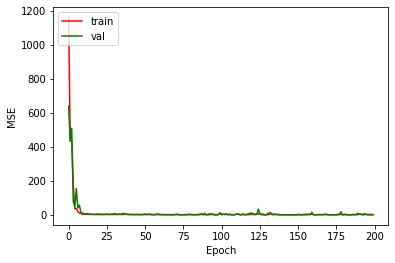

In [30]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [31]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])

(0.1063835620880127, 0.6928620934486389)

In [32]:
pred = neural_model.predict(z_test)
pred

array([[38.530434],
       [39.769123],
       [40.11396 ],
       [40.59124 ],
       [41.25162 ],
       [42.164974],
       [43.42614 ]], dtype=float32)

In [33]:
# ranz = np.random.uniform(0, np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z),31)

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranz)
pred_random

array([[33.69909 ],
       [35.116276],
       [36.533463],
       [37.65043 ],
       [38.46403 ],
       [39.277634],
       [39.809006],
       [39.959736],
       [40.110466],
       [40.261208],
       [40.412045],
       [40.56289 ],
       [40.71373 ],
       [40.86457 ],
       [41.01541 ],
       [41.166256],
       [41.317093],
       [41.467937],
       [41.618774],
       [41.76962 ],
       [41.920395],
       [42.071167],
       [42.22194 ],
       [42.372707],
       [42.523483],
       [42.674255],
       [42.825012],
       [42.97568 ],
       [43.12624 ],
       [43.276794],
       [43.42614 ]], dtype=float32)

In [34]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [35]:
fake_encoded = np.zeros((1, 31))

In [36]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))


(1, 31)
(31,)
(200, 31)


In [37]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/z[i]
    fake_encoded[0, i] = alpha * ranz[i]

In [38]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake)

(1, 961)

In [39]:
decoded_fake[0, :]

array([ 2.18475051e-02, -1.08336387e-02,  1.71343773e-03, -9.98639734e-06,
        8.32795864e-04,  7.29655439e-04,  6.11660827e-04,  8.94819677e-04,
        8.01267568e-04, -2.37044878e-06,  9.28890426e-04, -3.79753183e-05,
        3.10395495e-04,  4.16769995e-04,  3.68216773e-04,  4.93101194e-04,
        3.44090047e-04,  1.95315341e-04,  4.51866392e-04, -1.38759002e-04,
       -3.24578723e-05,  1.95146335e-04, -1.02353457e-04,  1.62918121e-04,
       -3.66718159e-05,  6.20905194e-04, -1.69133840e-04,  9.04047629e-05,
       -5.62444155e-04,  4.16760449e-05, -1.75783091e-04, -1.08777918e-02,
        2.79748254e-02, -2.39117723e-03,  1.99114531e-03, -1.50955311e-04,
        2.21257622e-04,  8.79555591e-05,  6.23011438e-04,  7.80234695e-05,
        2.30346486e-04,  4.87314363e-04,  3.69764806e-04,  2.31723534e-05,
        2.74415594e-04,  4.92545951e-04, -5.59870386e-05,  3.34262149e-04,
        5.01418544e-04,  3.31807038e-04,  5.71443466e-04,  1.03026920e-04,
       -1.11377201e-04, -

1.2863893e-07

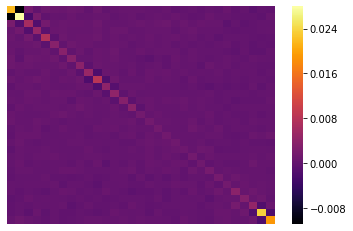

In [40]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

-0.01084098704 0.02815552265 0.00039265133851975654
-0.010877792 0.027974825 0.00038507715
-0.010845263 0.028159365 0.00038538207


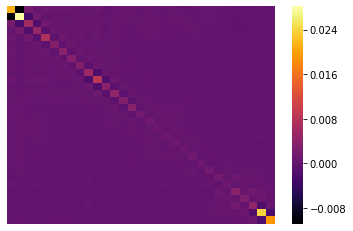

In [41]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal
print(np.min(clean_img[0,:]), np.max(clean_img[0,:]), np.mean(clean_img[0,:])) #checking non-negatives in the diagonal



In [42]:
np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLA_COVclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [43]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
            print(i,j, end=' ')
            print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

0 1 -0.010833639 -0.010877792
0 2 0.0017134377 0.0021560192
0 3 -9.986397e-06 0.0004228734
0 4 0.00083279586 0.00075594266
0 5 0.00072965544 0.00043314556
0 6 0.0006116608 0.0005683288
0 7 0.0008948197 0.0010925811
0 8 0.00080126757 0.0008374633
0 9 -2.3704488e-06 -7.049192e-05
0 10 0.0009288904 0.0007316937
0 11 -3.797532e-05 -0.00024652184
0 12 0.0003103955 0.00031044552
0 13 0.00041677 0.00041661723
0 14 0.00036821677 -0.00018641527
0 15 0.0004931012 0.00063286617
0 16 0.00034409005 0.00067682564
0 17 0.00019531534 -7.9111196e-05
0 18 0.0004518664 -0.00013963011
0 19 -0.000138759 0.0002905873
0 20 -3.2457872e-05 -0.00026316155
0 21 0.00019514633 9.886047e-05
0 22 -0.00010235346 0.00014305103
0 23 0.00016291812 -3.8879225e-06
0 24 -3.6671816e-05 -0.00017950911
0 25 0.0006209052 0.00020643248
0 26 -0.00016913384 0.00021080289
0 27 9.040476e-05 -0.00037869043
0 28 -0.00056244415 -0.00013348588
0 29 4.1676045e-05 -0.00016172638
0 30 -0.00017578309 0.00020884717
1 2 -0.0023911772 -0.0016

25 26 0.00020721694 0.00020687829
25 27 0.00062736974 0.0004061152
25 28 0.0002774318 0.00014111112
25 29 0.0003696205 0.00055259734
25 30 0.00030595108 0.0005588699
26 27 0.0004330044 0.0003919102
26 28 0.0010511952 0.0018519086
26 29 0.00050105585 0.00028618902
26 30 0.00010463297 0.00018764369
27 28 0.00043392857 0.00030982948
27 29 0.0009023305 0.0010431968
27 30 9.979907e-06 0.00020497758
28 29 -0.0017673974 -0.0016349704
28 30 0.0005332759 0.00066435576
29 30 -0.001922969 -0.0018851581


465

In [44]:
np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", header="#fake COV")

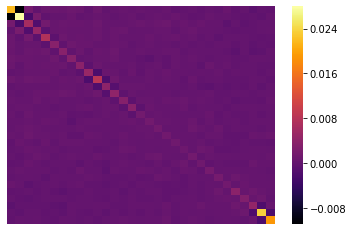

In [45]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [46]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)


np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")
fake_data


array([[1.00000000e-02, 3.36990891e+01],
       [5.30000000e-02, 3.51162758e+01],
       [9.60000000e-02, 3.65334625e+01],
       [1.39000000e-01, 3.76504288e+01],
       [1.82000000e-01, 3.84640312e+01],
       [2.25000000e-01, 3.92776337e+01],
       [2.68000000e-01, 3.98090057e+01],
       [3.11000000e-01, 3.99597359e+01],
       [3.54000000e-01, 4.01104660e+01],
       [3.97000000e-01, 4.02612076e+01],
       [4.40000000e-01, 4.04120445e+01],
       [4.83000000e-01, 4.05628891e+01],
       [5.26000000e-01, 4.07137299e+01],
       [5.69000000e-01, 4.08645706e+01],
       [6.12000000e-01, 4.10154114e+01],
       [6.55000000e-01, 4.11662560e+01],
       [6.98000000e-01, 4.13170929e+01],
       [7.41000000e-01, 4.14679375e+01],
       [7.84000000e-01, 4.16187744e+01],
       [8.27000000e-01, 4.17696190e+01],
       [8.70000000e-01, 4.19203949e+01],
       [9.13000000e-01, 4.20711670e+01],
       [9.56000000e-01, 4.22219391e+01],
       [9.99000000e-01, 4.23727074e+01],
       [1.042000

In [47]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(clean_img.reshape(31,31))))

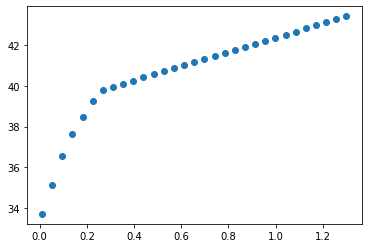

In [48]:
plt.scatter(ranz, pred_random)

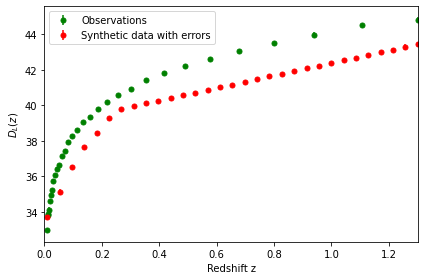

In [49]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
plt.savefig('fake_vs_binned_jla.png', dpi=200)

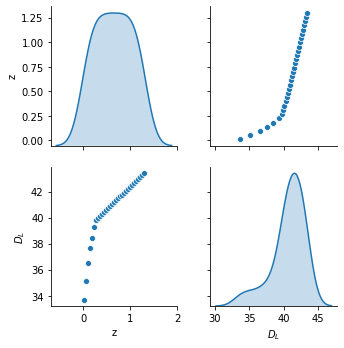

In [50]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')